In [414]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

Problem 1: 

4th order Runge Kutta

I took the step formula straight from class, and at the advice of Jon, I will not be attempting to derive it. If we are solving the ODE:

$ \frac{dy}{dx} = f(x,y)$

The fourth order RK timestep formula is given by:

$ y(x+h) = y(x) + \frac{1}{6}\bigg(  k_1 + 2k_2 + 2k_3 + k_4 \bigg)$

with:

$ k_1 = h f(x,y) $

$ k_2 = h f(x+\frac{h}{2}, y + \frac{k_1}{2}) $

$ k_3 = h f(x+\frac{h}{2}, y + \frac{k_2}{2}) $

$ k_4 = h f(x+h, y + k_3) $

Below, the function `derivative(x,y)` returns the $f(x,y) = \frac{y}{1+x^2}$, and the function `rk4_step` takes a function, two floats x, y, and the stepsize h and and computes and returns the RK4 time step above.

The function `integrate_func` takes a function `func`, an array `x`, a float `y0` and a `mode` which specifies whether the basic RK4 step should be used or the more sophisticated version to be developed below. It then computes the step size, and iterates over the `x` array and computes the corresponding `y` using the `rk4_step` or the `rk4_stepd`, subject to the condition $y(-20) = 1$.

Finally, I plot the the numerical result I got using `rk_step4` vs the analytic result:

$y(x) = \exp(\tan^{-1}(x) - \tan^{-1}(-20)) $

and the error for each x

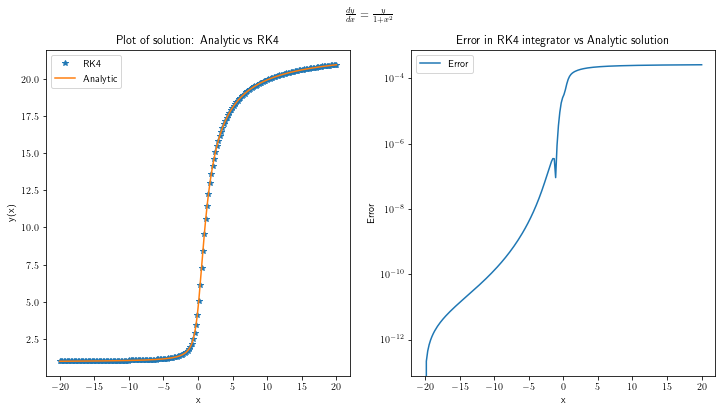

In [428]:
def derivative(x,y):
    return y/(1+x**2)

def rk4_step(fun, x, y, h):
    k1 = h * fun(x,y)
    k2 = h * fun(x+h/2, y + k1/2)
    k3 = h * fun(x+h/2, y + k2/2)
    k4 = h * fun(x+h, y+k3)
    
    return y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)


def integrate_func(func, x, y0val, mode = 'rk4'):
    h = x[1] - x[0]
    y= np.zeros(len(x))
    y[0] = y0val
    
    if mode == 'rk4':
        for i in range(len(x)-1):
            y[i+1] = rk4_step(derivative, x[i], y[i], h)
        
        return y
    
    elif mode == 'rk5':
        for i in range(len(x)-1):
            y[i+1] = rk4_stepd(derivative, x[i], y[i], h)
        
        return y
    


x = np.linspace(-20,20,200)


y_true = np.exp(np.arctan(x) - np.arctan(-20))
y = integrate_func(derivative, x, 1)

error = np.abs(y-y_true)

plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(1,2)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(x,y,'*',label = "RK4")
ax1.plot(x,y_true, label = "Analytic")
ax1.set_xlabel('x')
ax1.set_ylabel('y(x)')
ax1.set_title("Plot of solution: Analytic vs RK4")
ax1.legend()

ax2.semilogy(x, error, label = "Error")
ax2.set_xlabel("x")
ax2.set_ylabel("Error")
ax2.set_title("Error in RK4 integrator vs Analytic solution")
ax2.legend()

fig.suptitle('$\\frac{dy}{dx} = \\frac{y}{1+x^2}$')
plt.show()



For the next part, I compare a full step (of size h) using the RK4 algorithm, and two half steps (each of size h/2) and use a linear combination of these to cancel out a higher order Taylor error. We can do this because we know that:

$y_{\text{true}}(x+h) = y_{1}(x+h) + a h^5 $

$y_{\text{true}}(x+h) = y_{2}(x+h) + 2 a \frac{h^5}{2^5} $

where $a$ is related to the fifth derivative of $y$ somewhere in $[x,x+h]$ and is a constant (to within machine precision) as far as the RK4 steps are concerned. The first equation corresponds to a single step of size $h$ whereas the second one corresponds to two consecutive half steps each of size $h/2$. We can take an arbitrary weighted average of the two equations to get (to within $O(h^6)$:

$ y_{\text{true}}(x+h) = \frac{\alpha [y_{1}(x+h) + a h^5] + \beta [y_{2}(x+h) + a \frac{h^5}{2^4}]}{\alpha + \beta} = \frac{[\alpha y_{1}(x+h) + \beta y_{2}(x+h)] + a [\alpha + \frac{\beta}{16}] h^5}{\alpha + \beta}$

To make the coefficient of $h^5$ zero, choose $\alpha = - \frac{\beta}{16}$, which after some algebraic calculations simply gives:

$ y_{\text{true}}(x+h) = y_2(x+h) + \frac{y_2(x+h) - y_1(x+h)}{15}$

The function `rk4_stepd` first computes `y_full` = $y_1(x+h)$. It then computes the two consecutive half steps using the following formulae:

For the first half-step: 

$ y_m = y(x+\frac{h}{2}) = y(x) + \frac{1}{6}\bigg(  k'_1 + 2k'_2 + 2k'_3 + k'_4 \bigg)$

with:

$ k'_1 = \frac{h}{2} f(x,y)  = \frac{k_1}{2} $

$ k'_2 = \frac{h}{2} f(x+\frac{h}{4}, y + \frac{k'_1}{2}) = \frac{h}{2} f(x+\frac{h}{4}, y + \frac{k_1}{4})  $

$ k'_3 = \frac{h}{2} f(x+\frac{h}{4}, y + \frac{k'_2}{2}) $

$ k'_4 = \frac{h}{2} f(x+\frac{h}{2}, y + k'_3) $

(NB - I reused $k_1$ from the full step so as to not do an extra function call unnecessarily)

And for the second half-step:

$ y(x+h) = y_m + \frac{1}{6}\bigg(  k''_1 + 2k''_2 + 2k''_3 + k''_4 \bigg)$

with:

$ k''_1 = \frac{h}{2} f(x + \frac{h}{2},y_m)$

$ k''_2 = \frac{h}{2} f(x+\frac{3h}{4}, y + \frac{k''_1}{2})  $

$ k''_3 = \frac{h}{2} f(x+\frac{3h}{4}, y + \frac{k''_2}{2}) $

$ k''_4 = \frac{h}{2} f(x+h, y + k''_3) $

And compares the fifth order step with the fourth order step, and if the error is larger than $10^{-6}$, it returns the fifth order version, and if the error is smaller than that, it just returns the result of the two consecutive half steps. In this regime, the difference between the two approaches becomes of the order of machine precision so I though it may be best to avoid including this difference in the result.

To compare the two approaches in a somewhat fair fashion, I note that for each step, `rk4_step` makes 4 function calls, whereas `rk4_stepd` makes 11 = {(12) [1 for each $k, k' \text{ and } k''$] - (1) [because I reuse $k_1$ instead of recomputing $k'_1$]}, so I choose 220 steps for `rk_step` to compute $y(x)$ and $\frac{4}{11} \times 220 = 88 $ points for `rk4_stepd` to compute $y(x)$ and compare the results.

<Figure size 864x432 with 0 Axes>

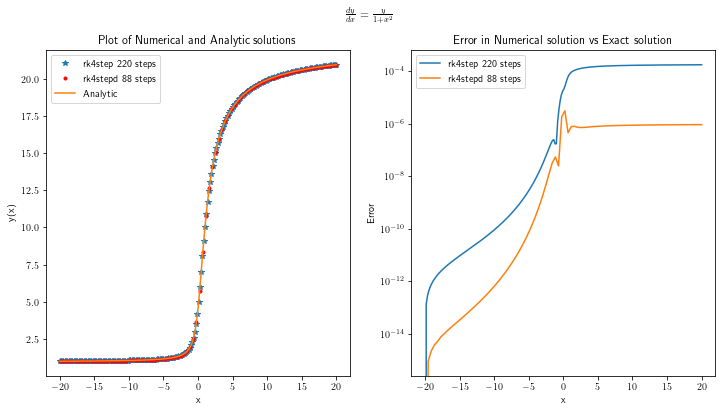

In [438]:
def rk4_stepd(fun,x,y,h):
    
    # full step
    k1 = h*fun(x,y)
    full_k2 = h * fun(x+h/2, y + k1/2)
    full_k3 = h * fun(x+h/2, y + full_k2/2)
    full_k4 = h * fun(x+h, y+full_k3)
    y_full = y + (1/6)*(k1 + 2*full_k2 + 2*full_k3 + full_k4)
    
    # first half step 
    fhalf_k2 = (h/2) * fun(x+h/4, y + k1/4)
    fhalf_k3 = (h/2) * fun(x+h/4, y + fhalf_k2/2)
    fhalf_k4 = (h/2) * fun(x+h/2, y+fhalf_k3)
    y1 = y + 1/6 * (k1/2 + 2*fhalf_k2 + 2*fhalf_k3 + fhalf_k4)
    
    # second half step
    shalf_k1 = (h/2) * fun(x+h/2, y1)
    shalf_k2 = (h/2) * fun(x+3*h/4, y1 + shalf_k1/2)
    shalf_k3 = (h/2) * fun(x+3*h/4, y1 + shalf_k2/2)
    shalf_k4 = (h/2) * fun(x+h, y1 + shalf_k3)
    
    y2 = y1 + 1/6 * (shalf_k1 + 2*shalf_k2 + 2*shalf_k3 + shalf_k4)
    
    
    if np.abs(y2 - y_full) > 1E-16:
        return y2 + (y2 - y_full)/15.
    
    else:
        return y2
    
    
x1 = np.linspace(-20, 20, 220)
x2 = np.linspace(-20, 20, 88)

y_rk4step = integrate_func(derivative, x1, 1)
y_rk4stepd = integrate_func(derivative, x2, 1, mode='rk5')
y_true1 = np.exp(np.arctan(x1) - np.arctan(-20))
y_true2 = np.exp(np.arctan(x2) - np.arctan(-20))

err1 = np.abs(y_true1 - y_rk4step)
err2 = np.abs(y_true2 - y_rk4stepd)

plt.clf()
fig, axs = plt.subplots(1,2)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(x1, y_rk4step, '*', label = "rk4step 220 steps")
ax1.plot(x2, y_rk4stepd, '.', c='r', label = "rk4stepd 88 steps")
ax1.plot(x1, y_true1, label = 'Analytic')
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y(x)")
ax1.set_title("Plot of Numerical and Analytic solutions")

ax2.semilogy(x1, err1, label = "rk4step 220 steps")
ax2.semilogy(x2, err2, label = "rk4stepd 88 steps")
ax2.set_xlabel("x")
ax2.set_ylabel("Error")
ax2.set_title("Error in Numerical solution vs Exact solution")
ax2.legend()

fig.suptitle('$\\frac{dy}{dx} = \\frac{y}{1+x^2}$')
plt.show()

In [439]:
print("RMS error for rk4_step() = ", np.std(err1))
print("RMS error for rk4_stepd() = ", np.std(err2))

RMS error for rk4_step() =  8.159376843579379e-05
RMS error for rk4_stepd() =  5.351828789310606e-07


`rk4_stepd()` is more accurate even though it only uses a fraction $\frac{4}{11} \approx 0.364$ of the steps used by `rk4_step()` integration to evaluate the integral! From the plot, the max error for `rk4_stepd()` is also lower than `rk4_step()`!

Problem 2

U-238 Decay Chain

I decided that I should choose a good unit of time to be able to capture all the dynamics reasonably. For this I settled on years as my units and converted all the half lives into years.

I looked up the table from the slides and if I was looking at the $i^{th}$ row, and if $y_i(t)$ was the concentration of that element, then for rows that are NOT the first or the last:

$ \frac{dy_i(t)}{dt} = \frac{y_{i-1}(t)}{\tau_{i-1}} - \frac{y_{i}(t)}{\tau_{i}} $

For the first row in the table:

$\frac{dy_1(t)}{dt} = - \frac{y_1(t)}{\tau_1} $

and for the last ($N^{th}$) row:

$\frac{dy_N(t)}{dt} = \frac{y_{N-1}(t)}{\tau_{N-1}} $.

My function `convert_to_years(lst)` takes a list of strings of half lives with an "end character" signifying the units used in the table from the slides and returns an array with all the half lives converted into years.

The function `decay(x,y,HL)` takes the time `x`, the array `y` and returns an array consisting of the `N` $\frac{dy_i(t)}{dt}$ from the equations above.

I put my initial time as `x0 = 0`, when `y0 = [1 0 0 0 ... 0]`, and my final time as `x1 = 1E16` which is significantly larger than the half life of U238 so I should be able to see all the interesting decays.

As the question suggested, I used scipy's integrator `solve_ivp` and since we have a large separation of time scales, the problem is quite stiff, so I set `method = 'Radau' ` which does an implicit RK4 time step. I then plot the required ratios by zooming in on time windows when the ratios are interesting. I plot the time axis on a log scale since we have a wide separation of time scales.

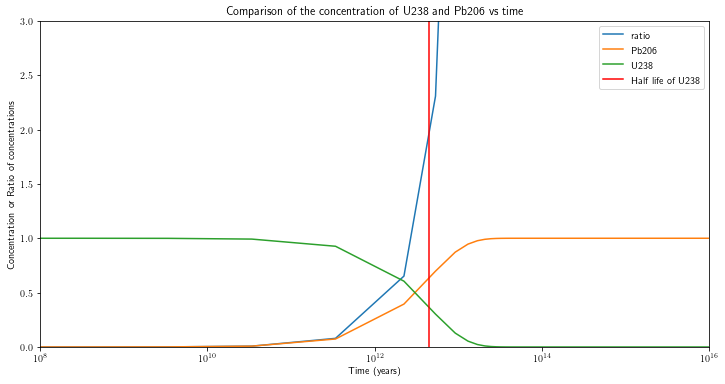

In [440]:
def convert_to_years(lst):
    half_life = np.zeros(len(lst))
    for i in range(len(lst)):
        timestr = lst[i]
        if timestr[-1] == 'y':
            half_life[i] = float(timestr[:-1])
        elif timestr[-1] == 'd':
            half_life[i] = float(timestr[:-1])/365
        elif timestr[-1] == 'h':
            half_life[i] = float(timestr[:-1])/365/24
        elif timestr[-1] == 'm':
            half_life[i] = float(timestr[:-1])/365/24/60
        elif timestr[-1] == 's':
            half_life[i] = float(timestr[:-1])/365/24/60/60
    return half_life
                
half_life_list = ['4468E9y', '24.10d', '6.70h', '245500y', '75380y', '1600y', '3.8235d', 
                  '3.10m', '26.8m', '19.9m', '164.3E-6s', '22.3y', '5015y', '138.376d']

def decay(x, y, HL = convert_to_years(half_life_list)):
    dydx = np.zeros(len(HL)+1)
    dydx[0] = -y[0]/HL[0]
    dydx[-1] = y[-2]/HL[-1]
    for i in range(1,np.size(dydx)-1):
        dydx[i] = y[i-1]/HL[i-1] - y[i]/HL[i]
    return dydx

x0 = 0
x1 = 1E16
y0 = np.zeros(15)
y0[0] = 1
from scipy import integrate
ans_stiff = integrate.solve_ivp(decay, [x0,x1], y0, method='Radau')

HL = convert_to_years(half_life_list)

plt.semilogx(ans_stiff.t, ans_stiff.y[-1,:]/ans_stiff.y[0,:], label='ratio')
plt.semilogx(ans_stiff.t, ans_stiff.y[-1,:], label="Pb206")
plt.semilogx(ans_stiff.t, ans_stiff.y[0,:], label = "U238")
plt.axvline(HL[0], label = "Half life of U238", c='r')
plt.xlim(1E8, 1E16)
plt.ylim(0, 3)
plt.legend()
plt.title("Comparison of the concentration of U238 and Pb206 vs time")
plt.xlabel("Time (years)")
plt.ylabel("Concentration or Ratio of concentrations")
plt.show()

While the ratio diverges, this is not unphysical, since it is to be expected that if we wait a little longer than the half-life life of U238, almost all the U238 would have decayed into Pb206. Then the concentration of U238 -> 0 and of Pb206 -> 1 $\implies$ ratio -> infinity.

<ipython-input-441-34e570f72461>:4: RuntimeWarning: invalid value encountered in true_divide
  ax1.semilogx(ans_stiff.t, ans_stiff.y[4,:]/ans_stiff.y[3,:], label='ratio')
<ipython-input-441-34e570f72461>:13: RuntimeWarning: invalid value encountered in true_divide
  ax2.loglog(ans_stiff.t, ans_stiff.y[4,:]/ans_stiff.y[3,:], label='ratio')


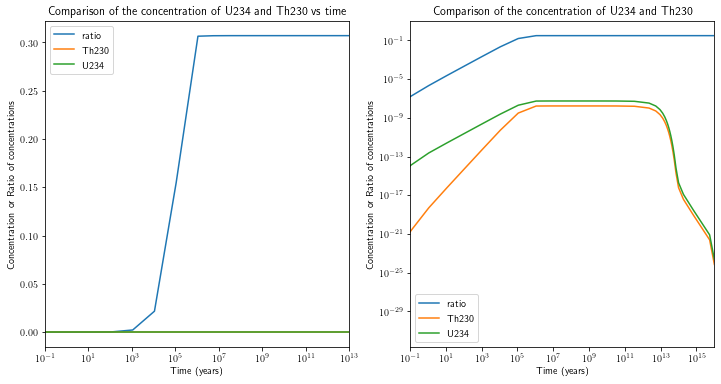

In [441]:
fig, axs = plt.subplots(1,2)
ax1 = axs[0]
ax2 = axs[1]
ax1.semilogx(ans_stiff.t, ans_stiff.y[4,:]/ans_stiff.y[3,:], label='ratio')
ax1.semilogx(ans_stiff.t, ans_stiff.y[4,:], label="Th230")
ax1.semilogx(ans_stiff.t, ans_stiff.y[3,:], label = "U234")
ax1.set_title("Comparison of the concentration of U234 and Th230 vs time")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Concentration or Ratio of concentrations")
ax1.set_xlim(0.1,1E13)
ax1.legend()

ax2.loglog(ans_stiff.t, ans_stiff.y[4,:]/ans_stiff.y[3,:], label='ratio')
ax2.loglog(ans_stiff.t, ans_stiff.y[4,:], label="Th230")
ax2.loglog(ans_stiff.t, ans_stiff.y[3,:], label = "U234")
ax2.set_title("Comparison of the concentration of U234 and Th230")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Concentration or Ratio of concentrations")
ax2.set_xlim(0.1,1E16)
ax2.legend()

plt.show()

We see that the equilibrium ratio $\approx 0.30$ is reached relatively quickly compared to the complete decay of U238. The constancy of the ratio is also not contradictory, since it so happens that both the concentrations fall but in a rather synchronized manner such that the ratio remains constant.

Problem 3:

Our model is $ z = p_0 + p_1 x + p_2 y + p_3 (x^2 + y^2) $, where each data point in our dataset is a triple $(x_i, y_i, z_i)$. This can be posed as a linear problem.

The original model was:

$z - z_0 = a((x-x_0)^2 + (y-y_0)^2) \implies z = z_0 + a(x^2 + y^2 + x_0^2 + y_0^2 - 2xx_0 - 2yy_0)$

$ \implies z = [z_0 + a x_0^2 + a y_0^2] + [-2 a x_0] x + [-2 a y_0 ] y + [a] (x^2 + y^2)$

Now, we can match coefficients with our trial model:

$ p_0 = z_0 + a x_0^2 + a y_0^2$

$ p_1 = -2 a x_0 $

$ p_2 = -2 a y_0 $

$ p_3 = a $

$ \implies x_0 = -\frac{p_1}{2 p_3} $

$  y_0 = -\frac{p_2}{2 p_3} $

$ z_0 = p_0 - \frac{(p_1^2 + p_2^2)}{4 p_3} $

$ a = p_3 $

First I read the data and split the columns. I also plot it to see what it looks like.

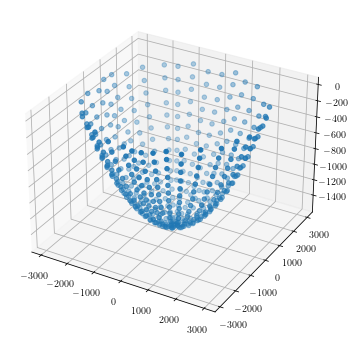

In [442]:
datafile_url = "https://raw.githubusercontent.com/sievers/phys512-2022/master/problem_sets/dish_zenith.txt"

data = np.loadtxt(datafile_url)

x_data = data[:,0]
y_data = data[:,1]
z_data = data[:,2]

plt.clf()
ax = plt.axes(projection='3d')
ax.scatter3D(x_data, y_data, z_data)
plt.show()

For each $(x_i, y_i, z_i)$ triplet, I can formulate the model as:

$ z_i = p_0 + p_1 x_i + p_2 y_i + p_3 (x_i^2 + y_i^2) $, which written as a matrix product looks like:


$$ \implies \begin{bmatrix} z_0 \\ z_1 \\ z_2 \\ . \\ . \\ z_{N} \end{bmatrix} = \begin{bmatrix} 
1 && x_0 && y_0 && x_0^2 + y_0^2 \\ 
1 && x_1 && y_1 && x_1^2 + y_1^2 \\
1 && x_2 && y_2 && x_2^2 + y_2^2  \\
. && . && . && .  \\
. && . && . && .   \\
1 && x_N && y_N && x_N^2 + y_N^2  
\end{bmatrix} \begin{bmatrix} p_0 \\ p_1 \\ p_2 \\ p_3 \end{bmatrix} $$

$ \implies \textbf{d} = \textbf{A} \cdot \textbf{p} $

I use `A = np.vstack((np.ones(N), x_data, y_data, x_data**2 + y_data**2))` which generates the transpose of the above $\textbf{A}$ and then take its transpose using `A = A.T` to get my polynomial matrix. 

Since I have no information on the noise, I will assume that the data is uncorrelated and that $\sigma(z_i) = 1$ for all $i$, i.e. $\textbf{N}$ from class is simply the identity matrix. We then have for the parameters that minimize $\chi^2$:

$ \textbf{p} = [\textbf{A}^{T} \textbf{A}]^{-1} [\textbf{A}^{T} \cdot \textbf{d}] $.

I compute this matrix and call it `fitp`. I checked the condition number and I see that it is rather large ($\approx 10^{13}$), so doing the matrix version using `np.linalg.inv` is technically okay. However, I decided to use SVD (the code I borrowed from class), but the idea is fairly simple. The condition for minimizing $\chi^2$ is 

$ \textbf{A}^{T} \textbf{A} \textbf{p} =  \textbf{A}^{T} \cdot \textbf{d} $. In doing the inverse naively as above, we might run into problems with very small eigenvalues of $ \textbf{A}^{T} \textbf{A}$. We can use SVD by writing (I will drop the boldface for matrices now):

$ A = U S V$ where $S$ is diagonal and $U,V$ are orthogonal. ($V$ not being the transpose is numpy convention).
Then $A^{-1} = V^T S^{-1} U^T $, $A^T = V^T S U^T$

$ [A^T A] \cdot p = [A^T] \cdot d \implies [V^T S U^T U S V] \cdot p = [V^T S U^T] \cdot d$

$\implies p = [V^T S^{-1} U^T] \cdot d$.

Precisely this is carried out in the lines `u,s,v=np.linalg.svd(A,0)` and `fitp=v.T@np.diag(1/s)@u.T@d`.

From this we can read off `a = fitp[3]`. 
Note - `model2` is my evaluation of the original model, once I've rewritten `a,z0,x0,y0` in terms of the `fitp`. There is a difference between `model` and `model2` of order $10^{-13}$ which might seem bad but is actually pretty good considering the original data is only to 32-bit precision.

Condition number for this model is:  76152791500365.88
Focal length is =  1499.6599841252175 mm
Target Focal Length = 1500 mm


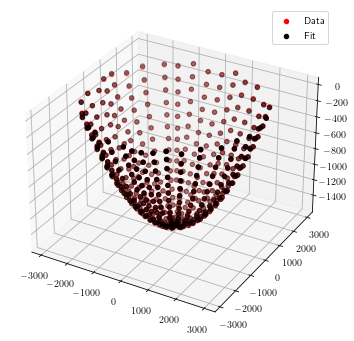

In [443]:
N = len(z_data)
A = np.vstack((np.ones(N), x_data, y_data, x_data**2 + y_data**2))
A = A.T
d = z_data.T


lhs = A.T @ A
rhs = A.T @ d

# fitp = np.linalg.inv(lhs)@rhs

e,V=np.linalg.eigh(lhs)
rcond=e.max()/e.min()
print("Condition number for this model is: ", rcond)

u,s,v=np.linalg.svd(A,0)
fitp=v.T@np.diag(1/s)@u.T@d

model = (A@fitp)

a = fitp[3]
z0 = fitp[0] - (fitp[1]**2 + fitp[2]**2)/(4.*fitp[3])
x0 = - fitp[1]/fitp[3]/2.
y0 = - fitp[2]/fitp[3]/2.


print("Focal length is = ", 1/(4*a), "mm")
print("Target Focal Length = 1500 mm")

model2 = z0 + a * ((x_data - x0)**2 + (y_data - y0)**2)

#print(np.max(np.abs(model-model2)))

plt.clf()
ax = plt.axes(projection='3d')
ax.scatter3D(x_data, y_data, z_data, c='r', label="Data")
ax.scatter3D(x_data, y_data, model, c='k', label="Fit")
ax.legend()

The focal length from the fit is indeed quite close to the target value! We can also look at a plot of the residuals to make sure it is roughly symmetric about zero. I assume here the data is rotationally invariant in the xy-plane so I plot the residual as a function of radial distance. While it appears that the data gets noisier (and the fit worse) for large r, the residuals do indeed appear to be symmetric about zero, as we needed.

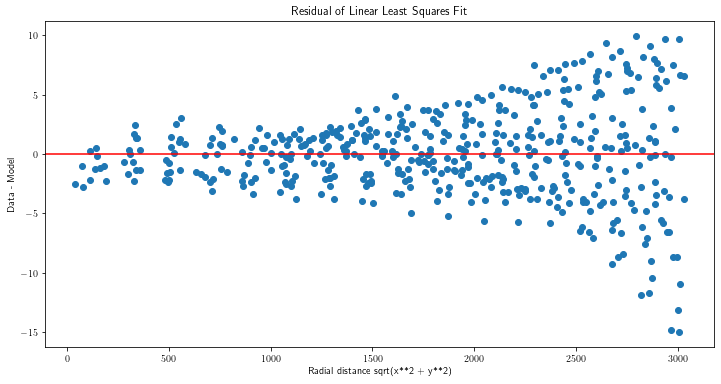

Number of points with negative Residual:  235
Number of points with positive Residual:  240
Fit Residual is  14.200376171924733


In [444]:
r_data = np.sqrt(x_data**2 + y_data**2)

plt.clf()
plt.scatter(r_data, z_data - model)
plt.axhline(0, c='r')
plt.xlabel("Radial distance sqrt(x**2 + y**2)")
plt.ylabel("Data - Model")
plt.title("Residual of Linear Least Squares Fit")
plt.show()

print("Number of points with negative Residual: ", np.size(np.where((z_data-model)<0)))
print("Number of points with positive Residual: ", np.size(np.where((z_data-model)>0)))
print("Fit Residual is ", np.var(z_data-model))

The residual is not too great, particularly because of the errors for large $r$. There is not too much we can do about this without additional input about the noise in the data, or without changing our model. To get the error on the focal length, we first need to find the error in $a$ which is also the error in `fitp[3]`. We saw the formula in class where: 

$ <(\delta p)_i (\delta p)_j> = [A^T N^{-1} A]^{-1} $

to get an estimate for the LHS, we can put $ \sigma^2 = <(p-d)^2> $ and $N^{-1} = \text{diag}\bigg [\frac{1}{\sigma^2} \bigg]$ as was done in class (i.e assume the data is uncorrelated and the noise is independent of z). This will return a diagonal matrix which can be reduced to a column vector. The last entry of this vector is the estimate of $(\delta a)^2$. (I take the square root of this in my code.) We can then use the formula:

$ a = \frac{1}{4f} \implies f = \frac{1}{4a} \implies |\delta f| = \frac{1}{4 a^2} \delta a$ to get the error in focal length. I print this value further down.

In [445]:
sigma = np.mean((model.T-z_data)**2)
perr=np.sqrt(sigma*np.diag(np.linalg.inv(lhs)))

foc_err = (1/4/a**2)*perr[3]
print("Error in the focal length is =", foc_err, "mm")

Error in the focal length is = 0.5804077581892865 mm


This means that our target focal length is within 1 standard deviation of our fit focal length, so all in all, the analysis isn't downright terrible!

$\textbf{BONUS}$

$\textit{Refer to the PDF in the git repo for the notes on this calculation as it is somewhat long and tedious to typeset in latex.}$ The basic ideas are:

(i) We need a new fit function: 

$ z = F + Ex + Dy + Cxy + By^2 + Ax^2 $

(ii) The focal lengths are now given by:

$ f_1 = \frac{1}{4a}$, $f_2 = \frac{1}{4b}$

with 

$ a = \frac{1}{2} \bigg[ A + B - \frac{C}{\sin{2 \theta}} \bigg] $

$ b = \frac{1}{2} \bigg[ A + B + \frac{C}{\sin{2 \theta}} \bigg] $

$ 2 \theta = \tan^{-1}{\frac{C}{B-A}} $

In [446]:
A_new = np.vstack((np.ones(N), x_data, y_data, x_data*y_data, y_data**2, x_data**2))
A_new = A_new.T
d = z_data.T

lhs2 = A_new.T @ A_new
rhs2 = A_new.T @ d

e2,V2=np.linalg.eigh(lhs2)
rcond=e2.max()/e2.min()
print("Condition number for this model is: ", rcond)

u2,s2,v2=np.linalg.svd(A_new,0)
fitp_new=v2.T@np.diag(1/s2)@u2.T@d

model_new = (A_new@fitp_new)

A = fitp_new[5]
B = fitp_new[4]
C = fitp_new[3]

angle = np.arctan(C/(B-A))

b = 0.5 * (B+A + C/np.sin(angle))
a = 0.5 * (B+A - C/np.sin(angle))

print("The new focal lengths along the principal axes are: ", 1/4/a, "mm", 1/4/b, "mm")

Condition number for this model is:  38295018657152.86
The new focal lengths along the principal axes are:  1508.4884408086896 mm 1490.2191212406312 mm


Considering our previous error in $f$ was about $0.6mm$, the dish is definitely not rotationally symmetric about the z-axis, i.e., it is not "round".

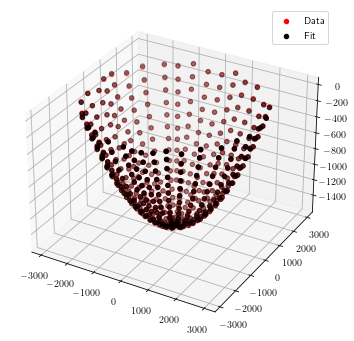

In [447]:
plt.clf()
ax = plt.axes(projection='3d')
ax.scatter3D(x_data, y_data, z_data, c='r', label="Data")
ax.scatter3D(x_data, y_data, model, c='k', label="Fit")
ax.legend()

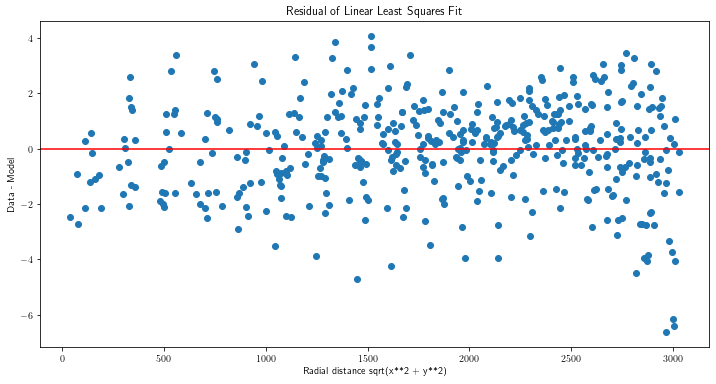

Number of points with negative Residual:  222
Number of points with positive Residual:  253
Fit Residual is  2.818881011679631


In [450]:
r_data = np.sqrt(x_data**2 + y_data**2)

plt.clf()
plt.scatter(r_data, z_data - model_new)
plt.axhline(0, c='r')
plt.xlabel("Radial distance sqrt(x**2 + y**2)")
plt.ylabel("Data - Model")
plt.title("Residual of Linear Least Squares Fit")
plt.show()

print("Number of points with negative Residual: ", np.size(np.where((z_data-model_new)<0)))
print("Number of points with positive Residual: ", np.size(np.where((z_data-model_new)>0)))
print("Fit Residual is ", np.var(z_data-model_new))

While it appears there is a slight bias toward negative residuals, it appears now that the data is indeed roughly randomly distributed about the residual=0 line and also the $\chi^2$ value is significantly lower (although we only added two extra degrees of freedom to the fit), so I think this new model is better representative of the data.